# Idealized Synthetic Data

*Under development*

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from IPython.display import display  # so can run as script too

from melodies_monet import driver

Please install h5py to open files from the Amazon S3 servers.
Please install h5netcdf to open files from the Amazon S3 servers.


In [2]:
an = driver.analysis()
an.control = "control_idealized.yaml"
an.read_control()
an

analysis(
    control='control_idealized.yaml',
    control_dict=...,
    models={},
    obs={},
    paired={},
    start_time=Timestamp('2019-09-09 00:00:00'),
    end_time=Timestamp('2019-09-10 00:00:00'),
    time_intervals=None,
    download_maps=True,
    output_dir='./output/idealized',
    output_dir_save='./output/idealized',
    output_dir_read='./output/idealized',
    debug=True,
    save={'paired': {'method': 'netcdf', 'prefix': 'asdf', 'data': 'all'}},
    read={'paired': {'method': 'netcdf', 'filenames': {'test_obs_test_model': 'asdf_test_obs_test_model.nc4'}}},
)

````{admonition} Note: This is the complete file that was loaded.
:class: dropdown

```{literalinclude} control_idealized.yaml
:caption:
:linenos:
```
````

## Generate data

### Model

In [3]:
rs = np.random.RandomState(42)

control = an.control_dict

nlat = 100
nlon = 200

lon = np.linspace(-161, -60, nlon)
lat = np.linspace(18, 60, nlat)
Lon, Lat = np.meshgrid(lon, lat)

time = pd.date_range(control['analysis']['start_time'], control['analysis']['end_time'], freq="3H")
ntime = time.size

# Generate translating and expanding Gaussian
x_ = np.linspace(-1, 1, lon.size)
y_ = np.linspace(-1, 1, lat.size)
x, y = np.meshgrid(x_, y_)
mu = np.linspace(-0.5, 0.5, ntime)
sigma = np.linspace(0.3, 1, ntime)
g = np.exp(
    -(
        (
            (x[np.newaxis, ...] - mu[:, np.newaxis, np.newaxis])**2
            + y[np.newaxis, ...]**2
        ) / ( 
            2 * sigma[:, np.newaxis, np.newaxis]**2
        ) 
    ) 
)

# Coordinates
lat_da = xr.DataArray(lat, dims="lat", attrs={'longname': 'latitude', 'units': 'degN'}, name="lat")
lon_da = xr.DataArray(lon, dims="lon", attrs={'longname': 'longitude', 'units': 'degE'}, name="lon")
time_da = xr.DataArray(time, dims="time", name="time")

# Generate dataset
field_names = control['model']['test_model']['variables'].keys()
ds_dict = dict()
for field_name in field_names:
    units = control['model']['test_model']['variables'][field_name]['units']
    # data = rs.rand(ntime, nlat, nlon)
    data = g
    da = xr.DataArray(
        data,
        # coords={"lat": lat_da, "lon": lon_da, "time": time_da},
        coords=[time_da, lat_da, lon_da],
        dims=['time', 'lat', 'lon'],
        attrs={'units': units},
    )
    ds_dict[field_name] = da
ds = xr.Dataset(ds_dict).expand_dims("z", axis=1)
ds["z"] = [1]

ds_mod = ds
ds_mod

<xarray.Dataset>
Dimensions:  (time: 9, lat: 100, lon: 200, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-09 2019-09-09T03:00:00 ... 2019-09-10
  * lat      (lat) float64 18.0 18.42 18.85 19.27 ... 58.73 59.15 59.58 60.0
  * lon      (lon) float64 -161.0 -160.5 -160.0 -159.5 ... -61.02 -60.51 -60.0
  * z        (z) int32 1
Data variables:
    A        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353
    B        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353

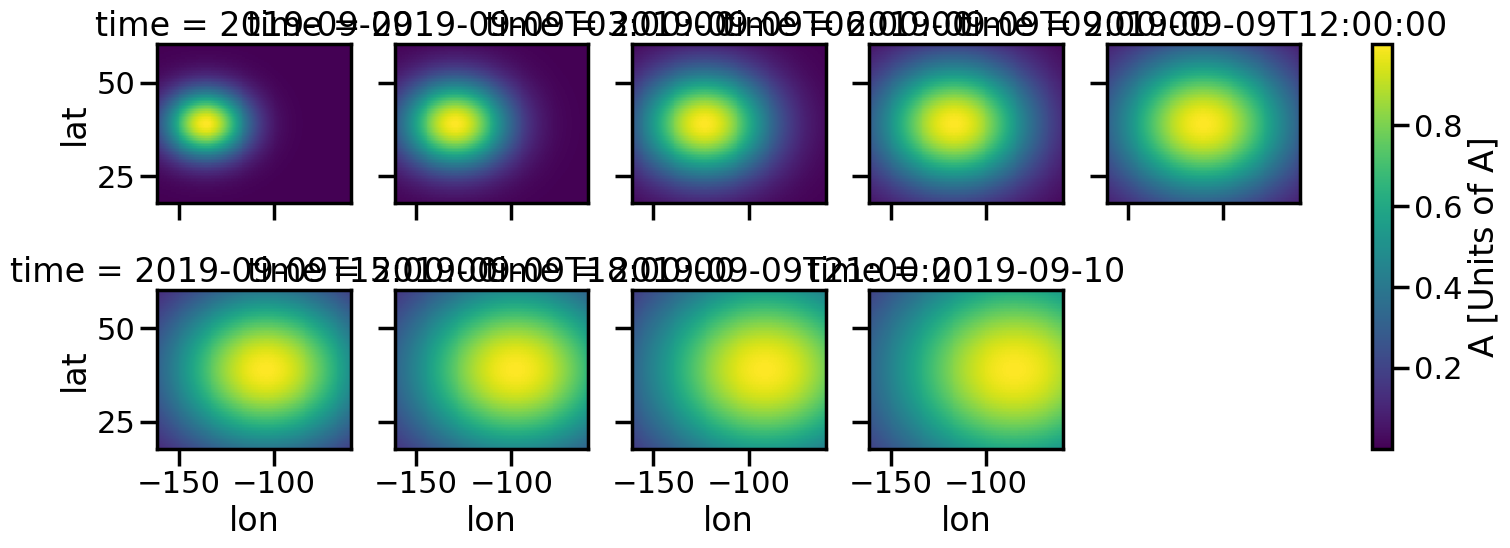

In [4]:
ds.squeeze("z").A.plot(col="time", col_wrap=5, size=3);

In [5]:
ds.to_netcdf(control['model']['test_model']['files'])

### Obs

In [6]:
from string import ascii_lowercase

# Generate positions
# TODO: only within land boundaries would be cleaner
n = 500
lats = rs.uniform(lat[0], lat[-1], n)
lons = rs.uniform(lon[0], lon[-1], n)
siteid = np.array([f"{x:0{len(str(n))}}" for x in range(n)])[np.newaxis, :]
something_vlen = np.array(
    [
        "".join(rs.choice(list(ascii_lowercase), size=x, replace=True))
        for x in rs.randint(low=2, high=8, size=n)
    ],
    dtype=str,
)[np.newaxis, :]

# Generate dataset
field_names = control['model']['test_model']['variables'].keys()
ds_dict = dict()
for field_name0 in field_names:
    field_name = control['model']['test_model']['mapping']['test_obs'][field_name0]
    units = control['model']['test_model']['variables'][field_name0]['units']
    values = (
        ds_mod.A.squeeze().interp(lat=xr.DataArray(lats), lon=xr.DataArray(lons)).values
        + rs.normal(scale=0.3, size=(ntime, n))
    )[:, np.newaxis]
    da = xr.DataArray(
        values,
        coords={
            "x": ("x", np.arange(n)),  # !!!
            "time": ("time", time),
            "latitude": (("y", "x"), lats[np.newaxis, :], lat_da.attrs),
            "longitude": (("y", "x"), lons[np.newaxis, :], lon_da.attrs),
            "siteid": (("y", "x"), siteid),
            "something_vlen": (("y", "x"), something_vlen),
        },
        dims=("time", "y", "x"),
        attrs={'units': units},
    )
    ds_dict[field_name] = da
ds = xr.Dataset(ds_dict)
ds

<xarray.Dataset>
Dimensions:         (x: 500, time: 9, y: 1)
Coordinates:
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * time            (time) datetime64[ns] 2019-09-09 ... 2019-09-10
    latitude        (y, x) float64 33.73 57.93 48.74 43.14 ... 21.26 58.92 59.42
    longitude       (y, x) float64 -90.49 -106.9 -129.7 ... -147.2 -65.03 -116.0
    siteid          (y, x) <U3 '000' '001' '002' '003' ... '497' '498' '499'
    something_vlen  (y, x) <U7 'xicjs' 'cvoaglq' 'uzxt' ... 'dzzfatw' 'poqhzl'
Dimensions without coordinates: y
Data variables:
    A_obs           (time, y, x) float64 0.21 0.1793 0.1735 ... 0.118 0.6552
    B_obs           (time, y, x) float64 -0.1099 -0.2269 ... 0.1155 0.6365

In [7]:
ds.to_netcdf(control['obs']['test_obs']['filename'])

## Load

In [8]:
an.open_models()

test_model.nc
**** Reading Unspecified model output. Take Caution...


In [9]:
an.models['test_model'].obj

<xarray.Dataset>
Dimensions:  (time: 9, lat: 100, lon: 200, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-09 2019-09-09T03:00:00 ... 2019-09-10
  * lat      (lat) float64 18.0 18.42 18.85 19.27 ... 58.73 59.15 59.58 60.0
  * lon      (lon) float64 -161.0 -160.5 -160.0 -159.5 ... -61.02 -60.51 -60.0
  * z        (z) int32 1
Data variables:
    A        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353
    B        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353

In [10]:
an.open_obs()

In [11]:
an.obs['test_obs'].obj

<xarray.Dataset>
Dimensions:         (x: 500, time: 9, y: 1)
Coordinates:
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * time            (time) datetime64[ns] 2019-09-09 ... 2019-09-10
    latitude        (y, x) float64 ...
    longitude       (y, x) float64 ...
    siteid          (y, x) object ...
    something_vlen  (y, x) object ...
Dimensions without coordinates: y
Data variables:
    A_obs           (time, y, x) float64 ...
    B_obs           (time, y, x) float64 ...

## Pair

In [12]:
%%time

an.pair_data()

After pairing:                      time   latitude   longitude siteid something_vlen  \
0    2019-09-09 00:00:00  33.730685  -90.485667    000          xicjs   
1    2019-09-09 03:00:00  33.730685  -90.485667    000          xicjs   
2    2019-09-09 06:00:00  33.730685  -90.485667    000          xicjs   
3    2019-09-09 09:00:00  33.730685  -90.485667    000          xicjs   
4    2019-09-09 12:00:00  33.730685  -90.485667    000          xicjs   
...                  ...        ...         ...    ...            ...   
4495 2019-09-09 12:00:00  59.420851 -115.953417    499         poqhzl   
4496 2019-09-09 15:00:00  59.420851 -115.953417    499         poqhzl   
4497 2019-09-09 18:00:00  59.420851 -115.953417    499         poqhzl   
4498 2019-09-09 21:00:00  59.420851 -115.953417    499         poqhzl   
4499 2019-09-10 00:00:00  59.420851 -115.953417    499         poqhzl   

         A_obs     B_obs         A         B  
0     0.209983 -0.109890  0.008033  0.008033  
1     0.17102

In [13]:
an.paired

{'test_obs_test_model': pair(
     type='pt_sfc',
     radius_of_influence=1000000.0,
     obs='test_obs',
     model='test_model',
     model_vars=['A', 'B'],
     obs_vars=['A_obs', 'B_obs'],
     filename='test_obs_test_model.nc',
 )}

In [14]:
an.paired['test_obs_test_model'].obj

<xarray.Dataset>
Dimensions:         (time: 9, x: 500)
Coordinates:
  * time            (time) datetime64[ns] 2019-09-09 ... 2019-09-10
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    something_vlen  (time, x) object 'xicjs' 'cvoaglq' ... 'dzzfatw' 'poqhzl'
    A_obs           (time, x) float64 0.21 0.1793 0.1735 ... 0.462 0.118 0.6552
    B_obs           (time, x) float64 -0.1099 -0.2269 0.05157 ... 0.1155 0.6365
    A               (time, x) float64 0.008033 0.001784 0.2917 ... 0.5939 0.5151
    B               (time, x) float64 0.008033 0.001784 0.2917 ... 0.5939 0.5151
    latitude        (x) float64 33.73 57.93 48.74 43.14 ... 21.26 58.92 59.42
    longitude       (x) float64 -90.49 -106.9 -129.7 ... -147.2 -65.03 -116.0
    siteid          (x) object '000' '001' '002' '003' ... '497' '498' '499'

In [15]:
an.paired['test_obs_test_model'].obj.dims

Frozen({'time': 9, 'x': 500})

## Plot

C:\Users\zmoon\git\MELODIES-MONET\melodies_monet\plots\surfplots.py:671: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean=df.groupby(['siteid'],as_index=False).mean()


C:\Users\zmoon\git\MELODIES-MONET\melodies_monet\plots\surfplots.py:671: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mean=df.groupby(['siteid'],as_index=False).mean()


CPU times: total: 5.3 s
Wall time: 5.31 s


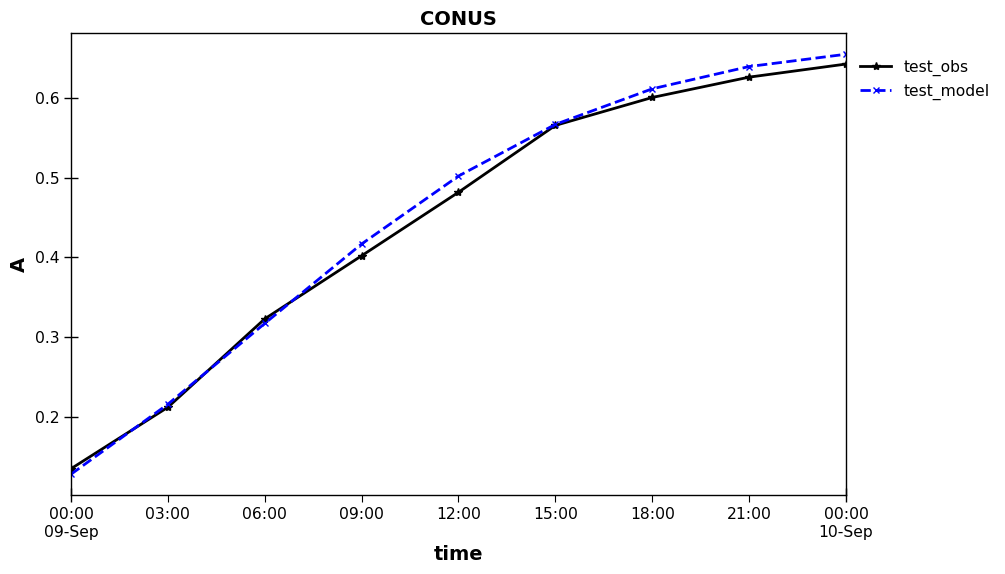

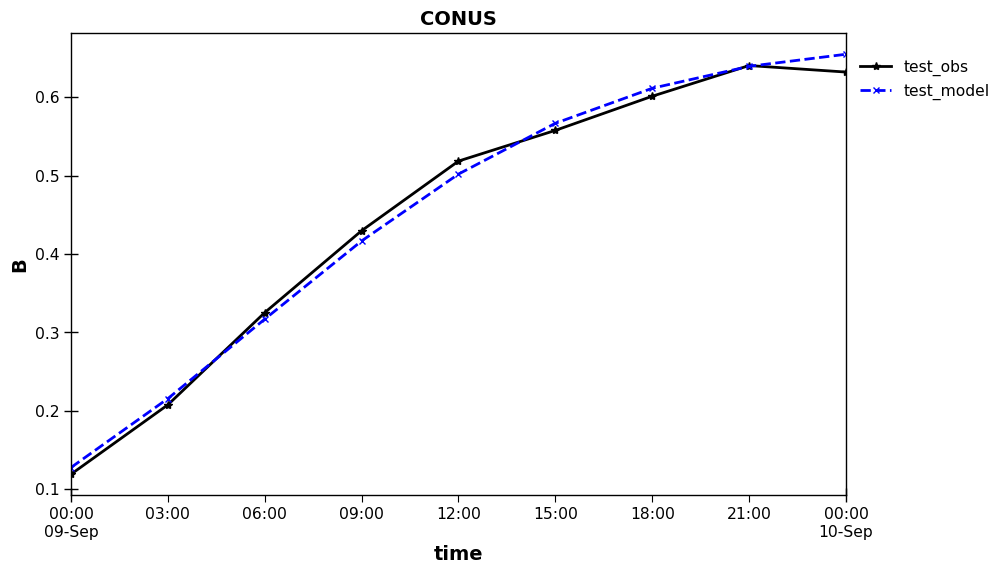

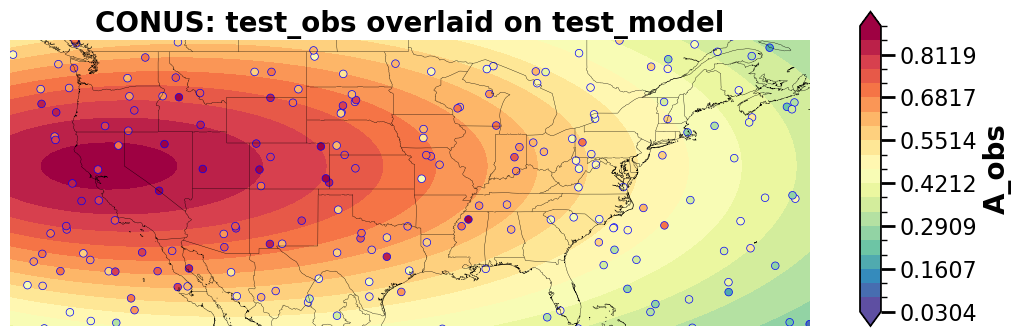

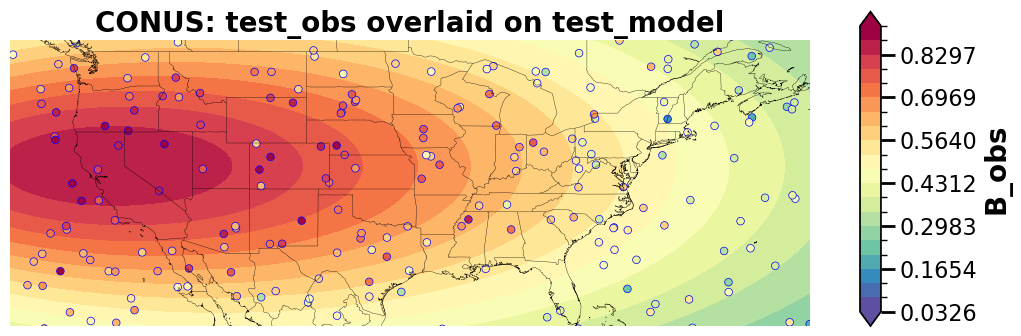

In [16]:
%%time

an.plotting()

## Save/load paired data -- netCDF

And compare to the original pair object.

In [17]:
from copy import deepcopy

p0 = deepcopy(an.paired['test_obs_test_model'].obj)

an.save_analysis()
an.read_analysis()
p1 = deepcopy(an.paired['test_obs_test_model'].obj)
p1.close()

display(p0)
display(p1)
assert p1 is not p0 and p1.equals(p0)

Writing: ./output/idealized\asdf_test_obs_test_model.nc4
Reading:  ./output/idealized\asdf_test_obs_test_model.nc4


<xarray.Dataset>
Dimensions:         (time: 9, x: 500)
Coordinates:
  * time            (time) datetime64[ns] 2019-09-09 ... 2019-09-10
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    something_vlen  (time, x) object 'xicjs' 'cvoaglq' ... 'dzzfatw' 'poqhzl'
    A_obs           (time, x) float64 0.21 0.1793 0.1735 ... 0.462 0.118 0.6552
    B_obs           (time, x) float64 -0.1099 -0.2269 0.05157 ... 0.1155 0.6365
    A               (time, x) float64 0.008033 0.001784 0.2917 ... 0.5939 0.5151
    B               (time, x) float64 0.008033 0.001784 0.2917 ... 0.5939 0.5151
    latitude        (x) float64 33.73 57.93 48.74 43.14 ... 21.26 58.92 59.42
    longitude       (x) float64 -90.49 -106.9 -129.7 ... -147.2 -65.03 -116.0
    siteid          (x) object '000' '001' '002' '003' ... '497' '498' '499'

<xarray.Dataset>
Dimensions:         (time: 9, x: 500)
Coordinates:
  * time            (time) datetime64[ns] 2019-09-09 ... 2019-09-10
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    something_vlen  (time, x) object ...
    A_obs           (time, x) float64 ...
    B_obs           (time, x) float64 ...
    A               (time, x) float64 ...
    B               (time, x) float64 ...
    latitude        (x) float64 ...
    longitude       (x) float64 ...
    siteid          (x) object ...
Attributes:
    title:         
    format:        NetCDF-4
    date_created:  2023-02-27
    dict_json:     {\n    "type": "pt_sfc",\n    "radius_of_influence": 10000...
    group_name:    test_obs_test_model

## Save/load paired data -- Python object

In [18]:
print(an.save)
an.save["paired"]["method"] = "pkl"
del an.save["paired"]["prefix"]
# We could leave `prefix` since unused, but we need to set `output_name`
an.save["paired"]["output_name"] = "asdf.joblib"
print("->", an.save)

print()
print(an.read)
an.read["paired"]["method"] = "pkl"
an.read["paired"]["filenames"] = "asdf.joblib"
print("->", an.read)

print()
an.save_analysis()
an.read_analysis()
p2 = deepcopy(an.paired['test_obs_test_model'].obj)
p2.close()

# display(p0)
display(p2)
assert p2 is not p0 and p2.equals(p0)

{'paired': {'method': 'netcdf', 'prefix': 'asdf', 'data': 'all'}}
-> {'paired': {'method': 'pkl', 'data': 'all', 'output_name': 'asdf.joblib'}}

{'paired': {'method': 'netcdf', 'filenames': {'test_obs_test_model': ['./output/idealized\\asdf_test_obs_test_model.nc4']}}}
-> {'paired': {'method': 'pkl', 'filenames': 'asdf.joblib'}}

Writing: ./output/idealized\asdf.joblib
Reading: ./output/idealized\asdf.joblib


<xarray.Dataset>
Dimensions:         (time: 9, x: 500)
Coordinates:
  * time            (time) datetime64[ns] 2019-09-09 ... 2019-09-10
  * x               (x) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    something_vlen  (time, x) object ...
    A_obs           (time, x) float64 ...
    B_obs           (time, x) float64 ...
    A               (time, x) float64 ...
    B               (time, x) float64 ...
    latitude        (x) float64 ...
    longitude       (x) float64 ...
    siteid          (x) object ...
Attributes:
    title:         
    format:        NetCDF-4
    date_created:  2023-02-27
    dict_json:     {\n    "type": "pt_sfc",\n    "radius_of_influence": 10000...
    group_name:    test_obs_test_model